In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt, iirnotch
from io import StringIO

In [2]:
file_path1 = 'emg+dataset+in+lower+limb/SEMG_DB1/A_TXT/5Amar.txt'

def load_and_process_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        content = '\n'.join(content.split('\n')[6:])
    
    data = pd.read_csv(StringIO(content), sep='\t', header=None, names=['RF', 'BF', 'VM', 'ST', 'FX'])
    data.dropna(inplace=True)
    data['Time'] = data.index
    return data

#Filtre passe-bande
def bandpass_filter(data, lowcut=20, highcut=450, fs=1000, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

#Filtre notch
def notch_filter(data, notch_freq=50, fs=1000, quality_factor=30):
    nyquist = 0.5 * fs
    freq = notch_freq / nyquist
    b, a = iirnotch(freq, quality_factor)
    return filtfilt(b, a, data)

#Normalisation des données
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

data = load_and_process_data(file_path1)

# Application des filtres et de la normalisation sur chaque signal
for col in ['RF', 'BF', 'VM', 'ST']:
    data[col] = bandpass_filter(data[col])
    data[col] = notch_filter(data[col])
    data[col] = normalize_data(data[col])

data["FX"]=abs(data["FX"])

print(data.head())

         RF        BF        VM        ST    FX  Time
0  0.383135  0.525085  0.508346  0.621178  46.7     0
1  0.421895  0.513289  0.509653  0.623542  46.8     1
2  0.417687  0.522427  0.516154  0.623859  47.1     2
3  0.412939  0.528682  0.521285  0.628174  46.9     3
4  0.410020  0.527494  0.517635  0.628557  47.1     4


In [3]:
# Détection améliorée des cycles de marche
signal = data['FX']
threshold = 0.5 * np.max(signal)  # Seuil ajusté dynamiquement

cycle_diffs = np.diff(np.where(signal > threshold)[0])
distance = int(np.mean(cycle_diffs)) if len(cycle_diffs) > 0 else 200  # Valeur par défaut

peaks, _ = find_peaks(signal, height=threshold, prominence=5, distance=distance)

# Vérification de la cohérence des cycles
if len(peaks) > 1:
    cycle_lengths = np.diff(peaks)
    mean_cycle_length = np.mean(cycle_lengths)
else:
    mean_cycle_length = 1000  # Valeur par défaut si un seul pic est trouvé

# Détection des débuts de cycles ajustés
shift_ratio = 0.7
adjusted_peaks = []
for i in range(len(peaks) - 1):
    shift_amount = int(mean_cycle_length * shift_ratio)
    adjusted_start = max(0, peaks[i] - shift_amount)
    adjusted_peaks.append(adjusted_start)

# Vérification et correction des cycles manquants
new_adjusted_peaks = [adjusted_peaks[0]]
for i in range(1, len(adjusted_peaks)):
    if adjusted_peaks[i] - new_adjusted_peaks[-1] > 0.6 * mean_cycle_length:
        new_adjusted_peaks.append(adjusted_peaks[i])

adjusted_peaks = new_adjusted_peaks

print(f'Nombre de débuts de cycles ajustés : {len(adjusted_peaks)}')
print(adjusted_peaks)

# Calcul du temps pour chaque cycle
cycle_times = []
for i in range(len(adjusted_peaks) - 1):
    start_time = data['Time'][adjusted_peaks[i]]
    end_time = data['Time'][adjusted_peaks[i + 1]]
    cycle_times.append(end_time - start_time)

print(f'Temps pour chaque cycle : {cycle_times}')

# Calcul du temps moyen des cycles **normaux** (excluant les cycles corrompus)
normal_cycle_times = [t for t in cycle_times if t < 1.80 * np.mean(cycle_times)]
mean_normal_cycle_time = np.mean(normal_cycle_times) if normal_cycle_times else np.mean(cycle_times)

print(f'Temps moyen des cycles normaux : {mean_normal_cycle_time:.2f}')

# Détection et correction des cycles anormaux
new_adjusted_peaks = []
for i in range(len(adjusted_peaks) - 1):
    start_time = data['Time'][adjusted_peaks[i]]
    end_time = data['Time'][adjusted_peaks[i + 1]]
    cycle_time = end_time - start_time

    if cycle_time >= 1.80 * mean_normal_cycle_time:
        num_splits = round(cycle_time / mean_normal_cycle_time)  # Nombre de nouveaux cycles
        print(f'Cycle anormal détecté entre {start_time:.2f}s et {end_time:.2f}s, divisé en {num_splits} cycles.')

        # Ajout des nouveaux débuts de cycle répartis uniformément
        for j in range(num_splits):
            new_peak = adjusted_peaks[i] + int(j * mean_normal_cycle_time / (data['Time'][1] - data['Time'][0]))
            new_adjusted_peaks.append(new_peak)
    else:
        new_adjusted_peaks.append(adjusted_peaks[i])

# Ajout du dernier pic s'il n'a pas été traité
if adjusted_peaks:
    new_adjusted_peaks.append(adjusted_peaks[-1])

adjusted_peaks = new_adjusted_peaks

# Affichage des nouveaux débuts de cycles
print(f'Nouveaux débuts de cycles ajustés : {adjusted_peaks}')

Nombre de débuts de cycles ajustés : 30
[963, 2211, 3466, 4726, 5976, 7355, 10302, 11707, 12909, 14128, 15425, 16752, 18113, 21497, 22723, 23988, 25284, 26594, 28014, 29474, 30830, 32039, 33237, 34471, 35773, 38963, 40251, 41468, 42693, 43939]
Temps pour chaque cycle : [1248, 1255, 1260, 1250, 1379, 2947, 1405, 1202, 1219, 1297, 1327, 1361, 3384, 1226, 1265, 1296, 1310, 1420, 1460, 1356, 1209, 1198, 1234, 1302, 3190, 1288, 1217, 1225, 1246]
Temps moyen des cycles normaux : 1286.73
Cycle anormal détecté entre 7355.00s et 10302.00s, divisé en 2 cycles.
Cycle anormal détecté entre 18113.00s et 21497.00s, divisé en 3 cycles.
Cycle anormal détecté entre 35773.00s et 38963.00s, divisé en 2 cycles.
Nouveaux débuts de cycles ajustés : [963, 2211, 3466, 4726, 5976, 7355, 8641, 10302, 11707, 12909, 14128, 15425, 16752, 18113, 19399, 20686, 21497, 22723, 23988, 25284, 26594, 28014, 29474, 30830, 32039, 33237, 34471, 35773, 37059, 38963, 40251, 41468, 42693, 43939]


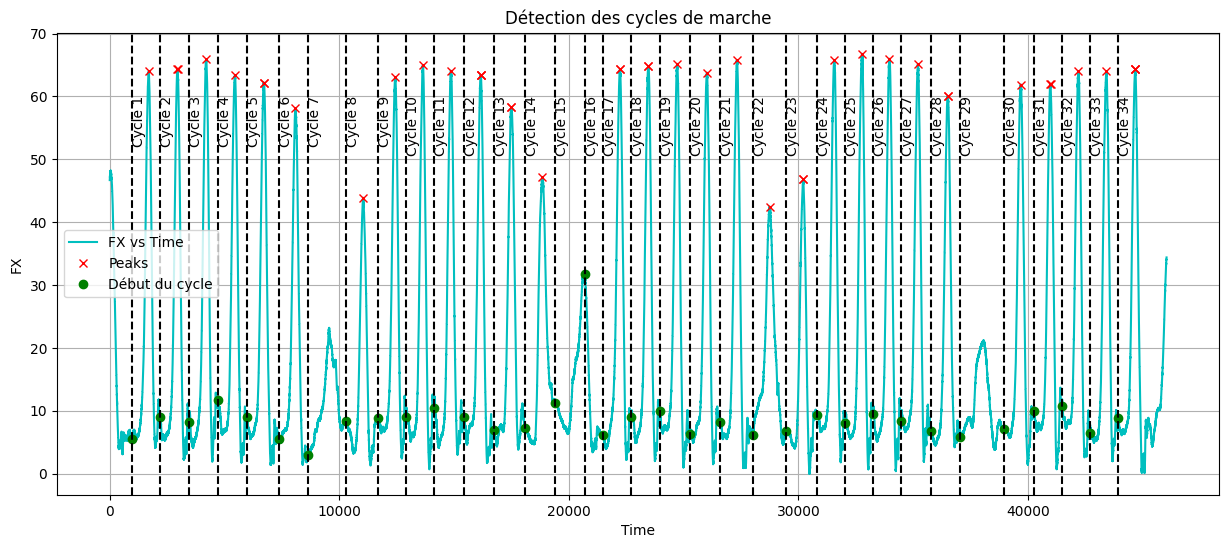

In [4]:
# Affichage du signal FX avec les cycles marqués
plt.figure(figsize=(15, 6))
plt.plot(data['Time'], data['FX'], label='FX vs Time', color='c')
plt.plot(data['Time'][peaks], data['FX'][peaks], 'rx', label='Peaks')
plt.plot(data['Time'][adjusted_peaks], data['FX'][adjusted_peaks], 'go', label='Début du cycle')

for i, start in enumerate(adjusted_peaks):
    plt.axvline(x=data['Time'][start], color='k', linestyle='--')
    plt.text(data['Time'][start], max(data['FX']) * 0.9, f'Cycle {i+1}', rotation=90, verticalalignment='top')

plt.xlabel('Time')
plt.ylabel('FX')
plt.title('Détection des cycles de marche')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
# On calcul le temps de chaque cycle et on divise par la fréquence d'échantillonnage pour obtenir le temps en secondes
cycle_durations = np.diff(adjusted_peaks) / 1000 

# Calcul du temps de cycle moyen
average_cycle_time = np.mean(cycle_durations)

print(f"Durée de chaque cycles (en secondes): {cycle_durations}")
print(f"Temps moyen de cycle (en secondes): {average_cycle_time}")

Durée de chaque cycles (en secondes): [1.248 1.255 1.26  1.25  1.379 1.286 1.661 1.405 1.202 1.219 1.297 1.327
 1.361 1.286 1.287 0.811 1.226 1.265 1.296 1.31  1.42  1.46  1.356 1.209
 1.198 1.234 1.302 1.286 1.904 1.288 1.217 1.225 1.246]
Temps moyen de cycle (en secondes): 1.3023030303030305
